In [1]:
import tensorflow as tf
import numpy
import matplotlib.pyplot as plt
stack = numpy.load('/Users/remydubois/Desktop/segmented/' + 'cm_IB_dapi_conf.npy')

In [30]:
import numpy
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = numpy.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = numpy.meshgrid(numpy.arange(shape[0]), numpy.arange(shape[1]))
    indices = numpy.reshape(y+dy, (-1, 1)), numpy.reshape(x+dx, (-1, 1))

    return map_coordinates(image, indices, order=1).reshape(shape)

(26, 3, 512, 512)


NameError: name 'elastic_transform' is not defined

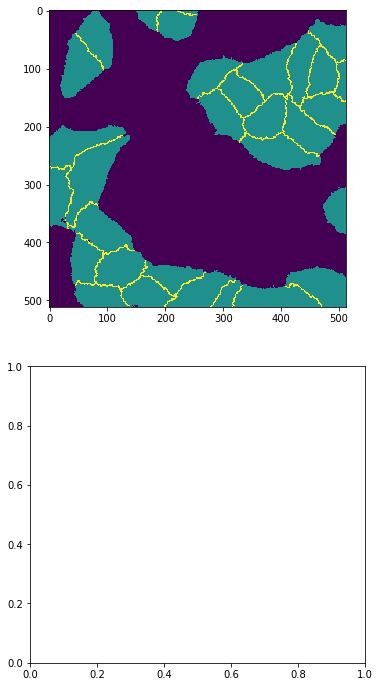

In [3]:
image = numpy.zeros((20, 20))
image[6:15, 6:15] = 1
image[7:14, 7:14] = 0
print(stack.shape)
f, ax = plt.subplots(nrows=2, figsize=(6, 12))
ax = ax.ravel()
ax[0].imshow(stack[0,1])
t = elastic_transform(stack[0,1], 45, 4.5)
a = ax[1].imshow(numpy.round(t).astype(int))
# f.colorbar(a)

In [43]:
%timeit elastic_transform(numpy.zeros((512, 512)), 5, 1)

44.9 ms ± 951 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
sess = tf.InteractiveSession()

In [2]:
t = tf.constant(numpy.stack([image[numpy.newaxis, :, :], numpy.roll(image[numpy.newaxis, :, :], 2)], axis=-1))
print(t.shape)
e = tf.nn.erosion2d(t, tf.ones((3, 3, 2), dtype='float64'), [1,1,1,1], [1,1,1,1], padding='SAME')
out = sess.run(t-e)
f, ax  = plt.subplots(nrows=2, figsize=(6, 12))
ax = ax.ravel()
ax[0].imshow(out[0, :, :, 0])
ax[1].imshow(out[0, :, :, 1])

NameError: name 'image' is not defined

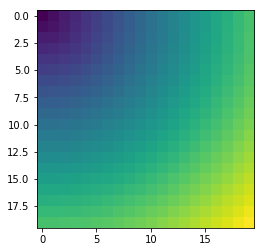

In [12]:
plt.imshow(image)
input = 1 - image
ft = numpy.zeros((input.ndim,) + input.shape,
                            dtype=numpy.int32)
dt = ft - numpy.indices(input.shape, dtype=ft.dtype)
dt = dt.astype(numpy.float64)
dt = numpy.multiply(dt, dt, dt)
dt = numpy.add.reduce(dt, axis=0)
dt = numpy.sqrt(dt)
plt.imshow(dt)

In [7]:
from skimage.io import imread
import os

root = '/Users/remydubois/Desktop/Remy/_REMY/hilo_tournant/Stacks/'

def gather_paths(root):
    paths = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            if name.lower().endswith('tif') and  '488' in name:
                paths.append(os.path.join(path, name))

    return paths

paths = gather_paths(root)

test = paths[0]

In [22]:
import numpy
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def read_and_mip(path):

    im = imread(path)    
    im = im.max(axis=0)
    
    return im

mips = Parallel(n_jobs=4, verbose=11)(delayed(read_and_mip)(p) for p in paths)


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0846s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    1.4s
[Pa

In [36]:
mips.pop(1)
stack = numpy.stack(mips)

numpy.save('/Users/remydubois/Desktop/segmented/CM_mips_only_hilo.npy', stack)

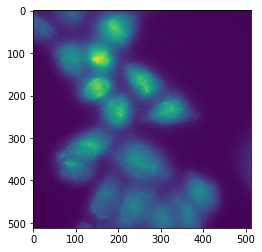

In [41]:
op = numpy.load('/Users/remydubois/Desktop/segmented/CM_mips_only_hilo.npy')
plt.imshow(op[12])